In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import json
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def getImage(path, zoom=1):
    return OffsetImage(plt.imread(path), zoom=zoom)

In [2]:
headers = {
    'authority': 'api.sofascore.com',
    'accept': '*/*',
    'accept-language': 'en-US,en;q=0.9',
    'cache-control': 'max-age=0',
    'dnt': '1',
    'if-none-match': 'W/"4bebed6144"',
    'origin': 'https://www.sofascore.com',
    'referer': 'https://www.sofascore.com/',
    'sec-ch-ua': '"Not.A/Brand";v="8", "Chromium";v="114"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"macOS"',
    'sec-fetch-dest': 'empty',
    'sec-fetch-mode': 'cors',
    'sec-fetch-site': 'same-site',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36',
}

In [3]:
response = requests.get('https://api.sofascore.com/api/v1/event/11352627/shotmap', headers=headers)

In [4]:
response.status_code

200

In [5]:
tiros = response.json()['shotmap']

In [6]:
tiros[0].keys()

dict_keys(['player', 'isHome', 'shotType', 'situation', 'playerCoordinates', 'bodyPart', 'goalMouthLocation', 'goalMouthCoordinates', 'blockCoordinates', 'xg', 'id', 'time', 'addedTime', 'timeSeconds', 'draw', 'reversedPeriodTime', 'reversedPeriodTimeSeconds', 'incidentType'])

In [7]:
tiros_partido = pd.DataFrame(tiros)

In [8]:
tiros_partido.head(2)

,player,isHome,shotType,situation,playerCoordinates,bodyPart,goalMouthLocation,goalMouthCoordinates,blockCoordinates,xg,id,time,addedTime,timeSeconds,draw,reversedPeriodTime,reversedPeriodTimeSeconds,incidentType,xgot,goalType
0,"{'name': 'Richarlison', 'firstName': '', 'last...",False,block,assisted,"{'x': 15, 'y': 57.3, 'z': 0}",right-foot,low-centre,"{'x': 0, 'y': 51.1, 'z': 19}","{'x': 12.3, 'y': 55.8, 'z': 0}",0.082999,2221875,90,10.0,5971,"{'start': {'x': 57.3, 'y': 15}, 'block': {'x':...",1,329,shot,NaN,NaN
1,"{'name': 'Richarlison', 'firstName': '', 'last...",False,save,regular,"{'x': 17.9, 'y': 50.4, 'z': 0}",right-foot,high-left,"{'x': 0, 'y': 52.7, 'z': 36.1}","{'x': 2.5, 'y': 50, 'z': 0}",0.047728,2221848,90,6.0,5702,"{'start': {'x': 50.4, 'y': 17.9}, 'block': {'x...",1,598,shot,0.3723,NaN


In [9]:
tiros_partido.columns

Index(['player', 'isHome', 'shotType', 'situation', 'playerCoordinates',
       'bodyPart', 'goalMouthLocation', 'goalMouthCoordinates',
       'blockCoordinates', 'xg', 'id', 'time', 'addedTime', 'timeSeconds',
       'draw', 'reversedPeriodTime', 'reversedPeriodTimeSeconds',
       'incidentType', 'xgot', 'goalType'],
      dtype='object')

In [10]:
df_xG = tiros_partido[['isHome', 'shotType', 'xg', 'time', 'addedTime']]

In [11]:
df_xG['xg'] = df_xG.xg.fillna(0)

<ipython-input-11-2135782400f6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xG['xg'] = df_xG.xg.fillna(0)


In [12]:
local_xG = df_xG[df_xG['isHome'] == True].sort_values(by='time').reset_index(drop=True)
visit_xG = df_xG[~df_xG['isHome'] == True].sort_values(by='time').reset_index(drop=True)

In [13]:
local_xG['xG_cumsum'] = local_xG.xg.cumsum()
visit_xG['xG_cumsum'] = visit_xG.xg.cumsum()

In [14]:
goles_local = local_xG[local_xG['shotType'] == 'goal']
goles_visit = visit_xG[visit_xG['shotType'] == 'goal']

In [15]:
goles_visit

,isHome,shotType,xg,time,addedTime,xG_cumsum
5,False,goal,0.125447,42,NaN,0.692602
7,False,goal,0.340573,55,NaN,1.205796


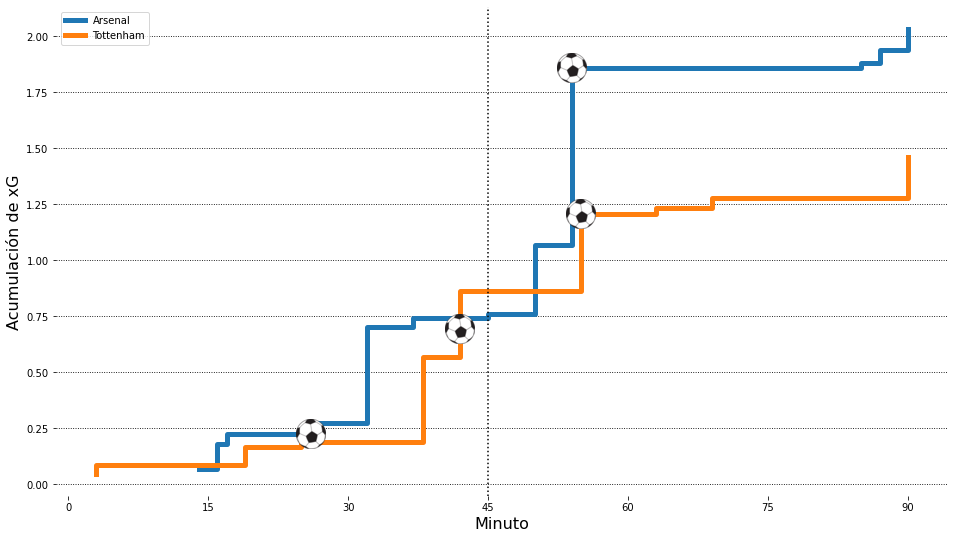

In [20]:
fig, ax = plt.subplots(figsize = (16,9))
fig.set_facecolor('white')
ax.patch.set_facecolor('white')
ax.grid(ls='dotted',lw=.9,color='black',axis='y',zorder=1)
spines = ['top','bottom','left','right']
for x in spines:
    if x in spines:
        ax.spines[x].set_visible(False)

plt.xticks([0,15,30,45,60,75,90])
plt.xlabel('Minuto',color='black',fontsize=16)
plt.ylabel('Acumulación de xG',color='black',fontsize=16)
ax.step(x=local_xG['time'], y=local_xG['xG_cumsum'],where='post', linewidth=5,label='Arsenal')
ax.step(x=visit_xG['time'], y=visit_xG['xG_cumsum'],where='post', linewidth=5,label='Tottenham')
ax.axvline(45, ls=':', color='black', lw=1.5)

goles = [goles_local, goles_visit]

for gol in goles:
    for x0, y0 in zip(gol['time'], gol['xG_cumsum']):
        ab = AnnotationBbox(getImage('C:/Users/Federico Rábanos/Documents/lanus stats/Python/Twitch_YouTube/archivos/pelota-modified (1).png'), (x0, y0), frameon=False)
        ax.add_artist(ab)

ax.legend()

plt.savefig('thumbnail transparente.png', dpi=400, bbox_inches='tight', transparent=True)